In [1]:
#for evaluate

In [2]:
'''
실험은 여기서 진행하면 될거야
원래 run 함수 만들어서 한방에 돌아가도록 하려했는데 사용자한테 threshold 받아오려면 오히려 비효율적일것 같더라고
최종 목적은 웹이나 시각화 툴 혹은 python 시각화 라이브러리 이용하는 거니까 우선은 이 파일로 실험 진행하고 나중에 프로그램적으로 돌려야겠다 싶으면
그 때 만들어도 될 것 같다.

필요할 것 같은 함수들은 만들어 뒀는데 추가로 필수적인 함수 있으면 구현해서 사용하면 되고 기호에 맞게 수정해도 돼
그리고 함수 추가하거나 수정한 후에 PR 할때는 꼭 말해주고
'''

'\n실험은 여기서 진행하면 될거야\n원래 run 함수 만들어서 한방에 돌아가도록 하려했는데 사용자한테 threshold 받아오려면 오히려 비효율적일것 같더라고\n최종 목적은 웹이나 시각화 툴 혹은 python 시각화 라이브러리 이용하는 거니까 우선은 이 파일로 실험 진행하고 나중에 프로그램적으로 돌려야겠다 싶으면\n그 때 만들어도 될 것 같다.\n\n필요할 것 같은 함수들은 만들어 뒀는데 추가로 필수적인 함수 있으면 구현해서 사용하면 되고 기호에 맞게 수정해도 돼\n그리고 함수 추가하거나 수정한 후에 PR 할때는 꼭 말해주고\n'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# cd [your src path]
%cd /content/drive/MyDrive/bistelligence/BISTelligence/src

/content/drive/MyDrive/bistelligence/BISTelligence/src


In [5]:
%pip install pyod tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=4061e22664b8aad690c32cdf78489ed6f84176fa65ac697cb61d894ea413bdd8
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [6]:
from sklearn.utils.validation import check_is_fitted
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
     
import data.preprocessing as dp
import model.models as mm

In [7]:
path = '/content/drive/MyDrive/bistelligence/BIS_data/BISTelligen_Project_Data.csv'
train_data, test_data = 0, 0
threshold = 0

trainer = mm.ModelTrain()

In [8]:
def SetData(scaled=True, key_num = -1):
  global train_data, test_data

  train_data, test_data = dp.GetPreprocessedData(path, scaled, key_num = key_num)

In [9]:
def GetModel(model_name='MCD', param_dict={}):
  '''
  [default value in 'ModelTrain' Class]
  param_dict={'contamination':0.01,
                     'novelty':True,
                     'random_state':42,
                     'n_conponents':1,
                     'cv_type':'full',
                     'momentum':0.9,
                     'learning_rate':0.03,
                     'epochs':100,
                     'patience':10}
  '''

  global trainer

  trainer.SetTrainer(train_data)
  trainer.SetParam(param_dict)
  model = trainer.GetTrainedModel(model_name)

  return model

In [10]:
def GetAnomalyScore(model=None):
  '''
  모델의 anomaly score return

  나중에 웹이나 시각화 툴로 health index 나타낼 때, (x,y)값 입력해야하는 경우 필요할 것 같아서 만듦.
  혹시 필요 없더라도 문제 없으니까 구현
  '''

  
  model_name = type(model).__name__

  if model_name in ['MCD','LOF','GMM']:
    anomaly_score = model.decision_function(test_data)

  elif model_name in ['OCSVM','IForest']:
    anomaly_score = model.decision_function(test_data) + np.abs(np.min(model.decision_function(test_data)))

  else:
    reconstruction = model.predict(test_data)
    anomaly_score = np.mean(np.power(test_data-reconstruction,2),axis=1)
    

  return anomaly_score

In [11]:
def ShowHealthIndex(model = None, anomaly_score = None, scaled = True, key_num = 123456):
  '''
  GetAnomalyScore로 이상치 점수 받아온 후, health index plot을 도출
  png로 저장 혹은 단순 plot 도출
  '''
  #plt.rcParams['figure.figsize'] = (12, 8)
  model_name = type(model).__name__
  if model_name == 'Sequential':
    model_name = 'AutoEncoder'
  sns.scatterplot(range(len(anomaly_score)), anomaly_score)
  plt.title('{} health index in key {} '.format(model_name, key_num ,scaled), fontsize = 25)
  #plt.show()

In [12]:
def DoXAI(model=None):
  '''
  더 잘맞는 함수 이름으로 바꿔도 괜찮고, 파라미터도 상황에 맞게 변경 가능
  (threshold를 입력받아야 XAI가 진행될 수도 있다고 생각되는데 그럴 경우, SetThreshold() 함수를 만들어서 threshold에 값 저장시킬 필요 있음.)
  XAI 폴더의 xai.py(가명)의 함수들을 실행시키는 함수
  
  xai.py(가명)의 함수들은 shap에서 지원하는 여러가지 plot을 그리고, png 파일로 XAI 폴더 내에 저장하는 동작으로 가정
  따라서 DoXAI()를 실행하면 XAI 폴더 내에 여러 plot png파일이 생성되는것을 생각하고 만듦
  '''  
  pass

In [13]:
def SaveBestModel(model):
  # model.saved_model 폴더에 모델 저장
  %cd /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model
  filename = '_'.join(['best', type(model).__name__])
  joblib.dump(model, filename)

In [14]:
def LoadBestModel(model):
  %cd /content/drive/MyDrive/bistelligence/BISTelligence/src/model/saved_model
  filename = '_'.join(['best', type(model).__name__])
  model = joblib.load(filename)
  return model

In [15]:
SetData()

# MCD 

2.240832948074908
1.7149244918039968
1.10032024821579
1.5548842390435667
1.6191689826974165
1.0356595263985235


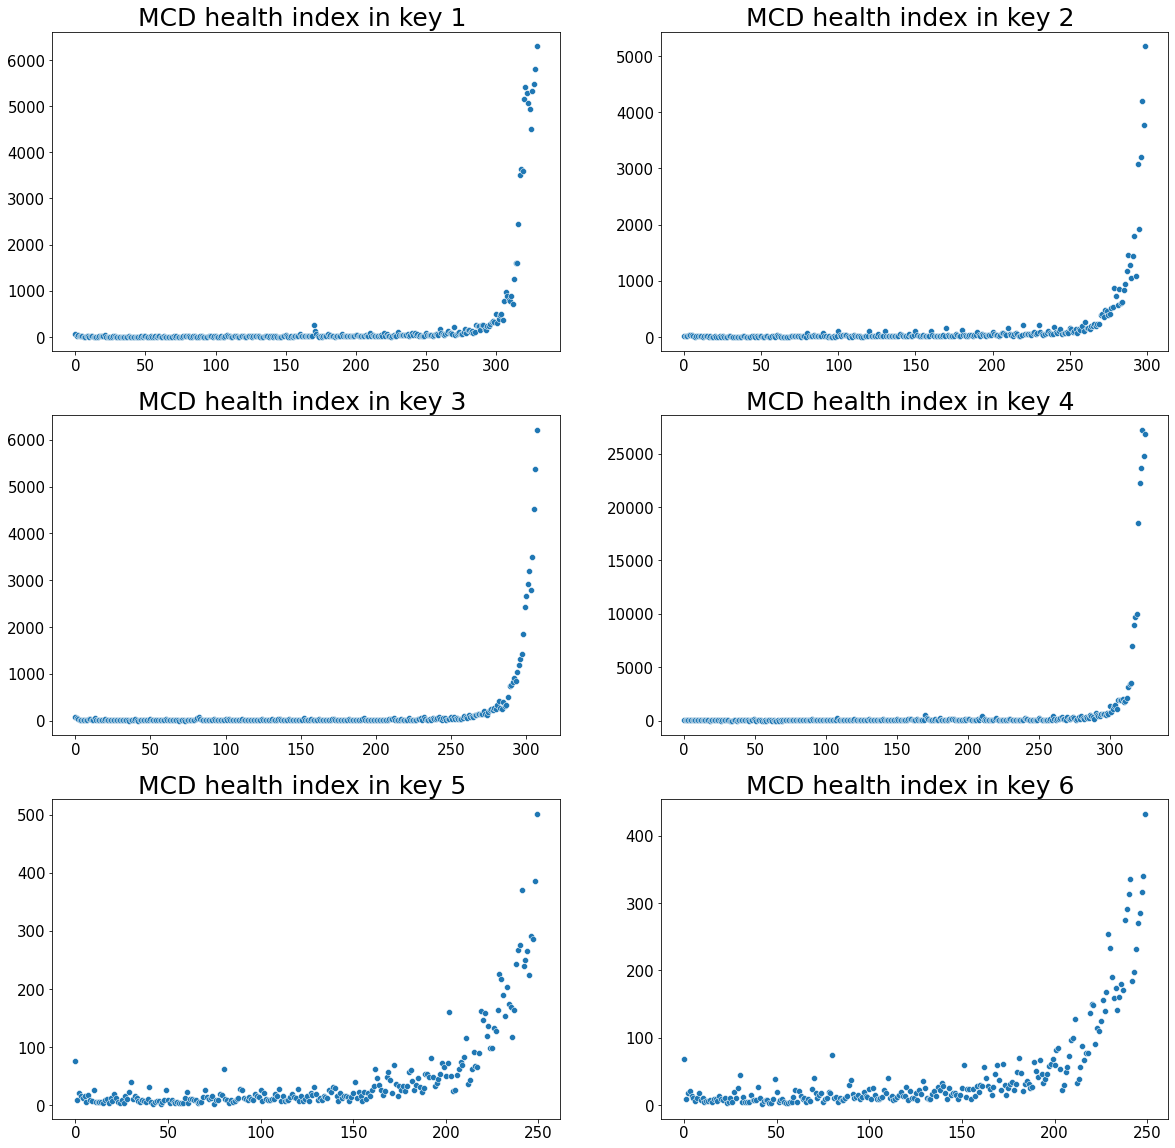

In [39]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'MCD')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

2.240832948079976
1.7149244918057125
1.1003202482210777
1.554884239042989
1.6191689827418025
1.0356595263961323


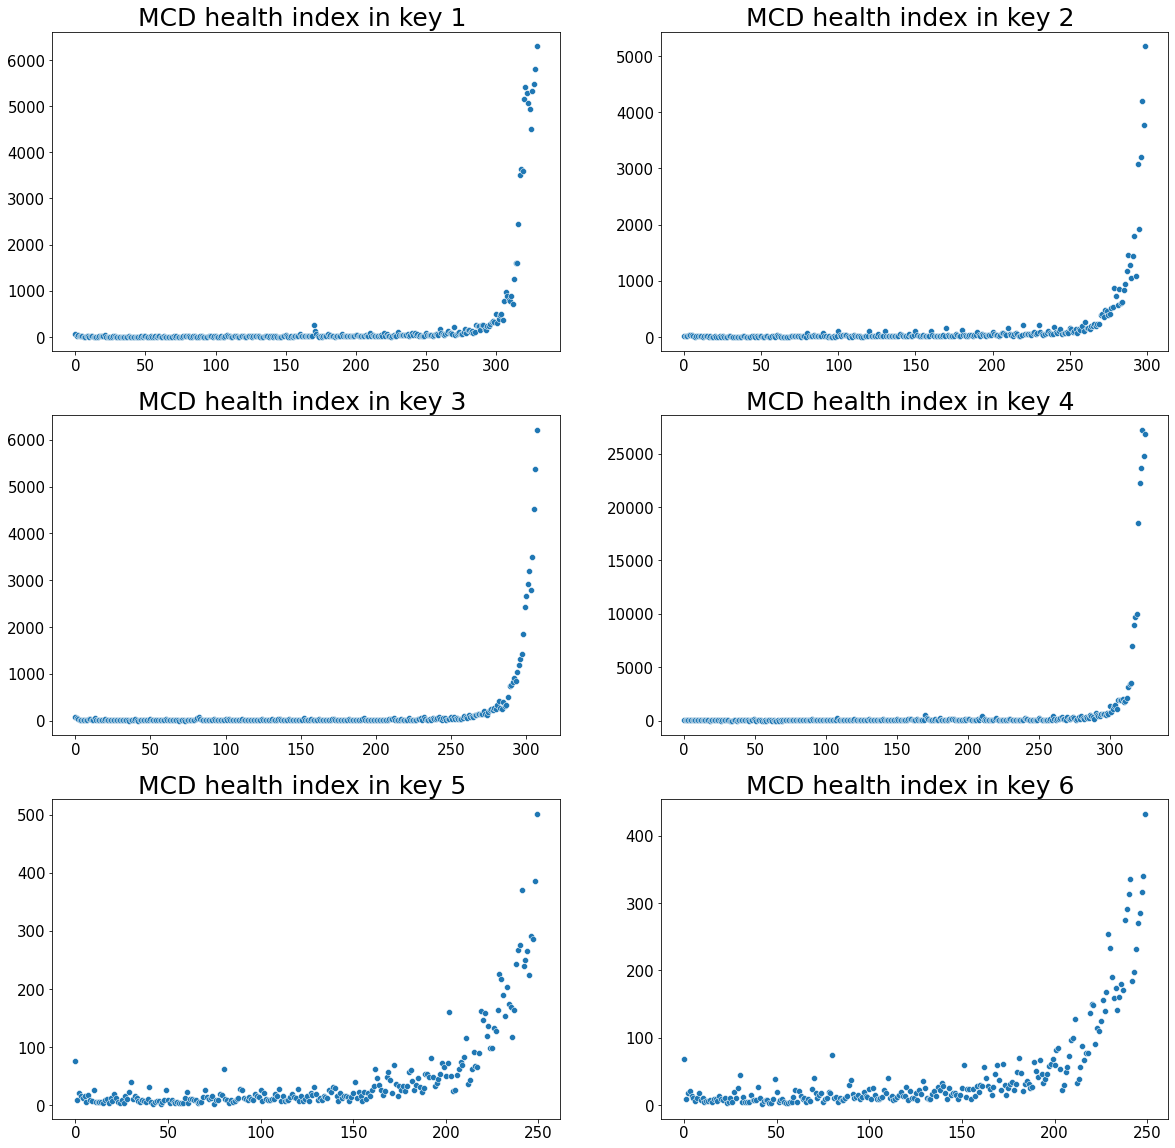

In [40]:
# scale X
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'MCD')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

# LOF

0.9444654321484112
0.9459494809399506
0.9552377988682785
0.9476036015637778
0.9568021793130659
0.9524290753083148
LOF(algorithm='auto', contamination=0.01, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=30, novelty=True, p=2)


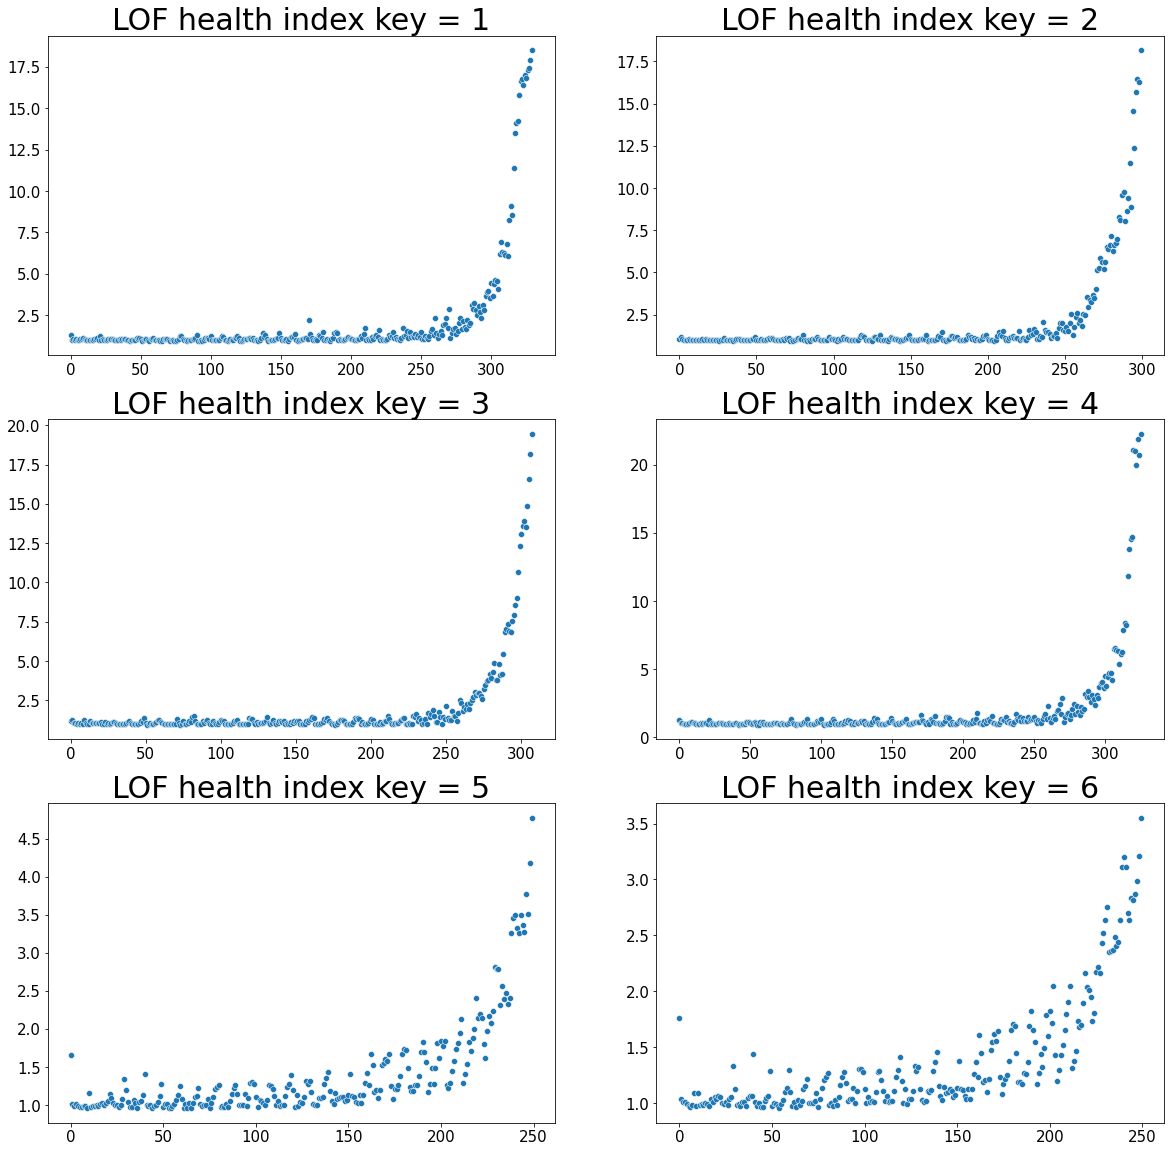

In [41]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'LOF',param_dict = {'n_neighbors':30})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

0.96667119817097
0.951498487862923
0.9588848771183793
0.9738105080867768
0.96355610484187
0.9679719112111584
LOF(algorithm='auto', contamination=0.01, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=30, novelty=True, p=2)


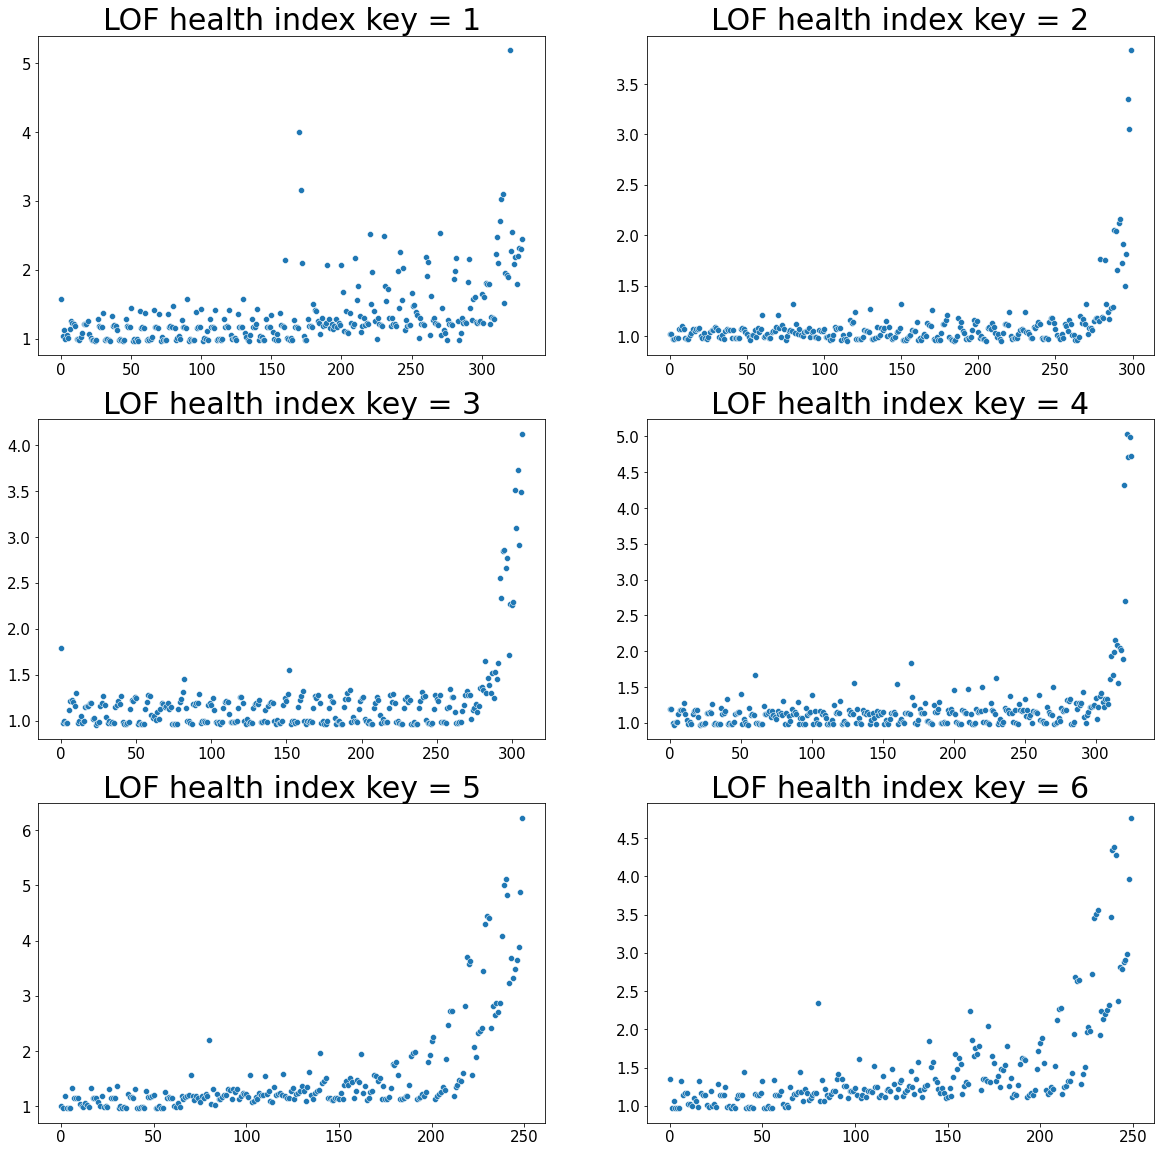

In [42]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'LOF', param_dict = {'n_neighbors': 30, 'contamination': 0.01})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

# OCSVM

OCSVM(cache_size=200, coef0=0.0, contamination=0.01, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.01, shrinking=True, tol=0.001,
   verbose=False)


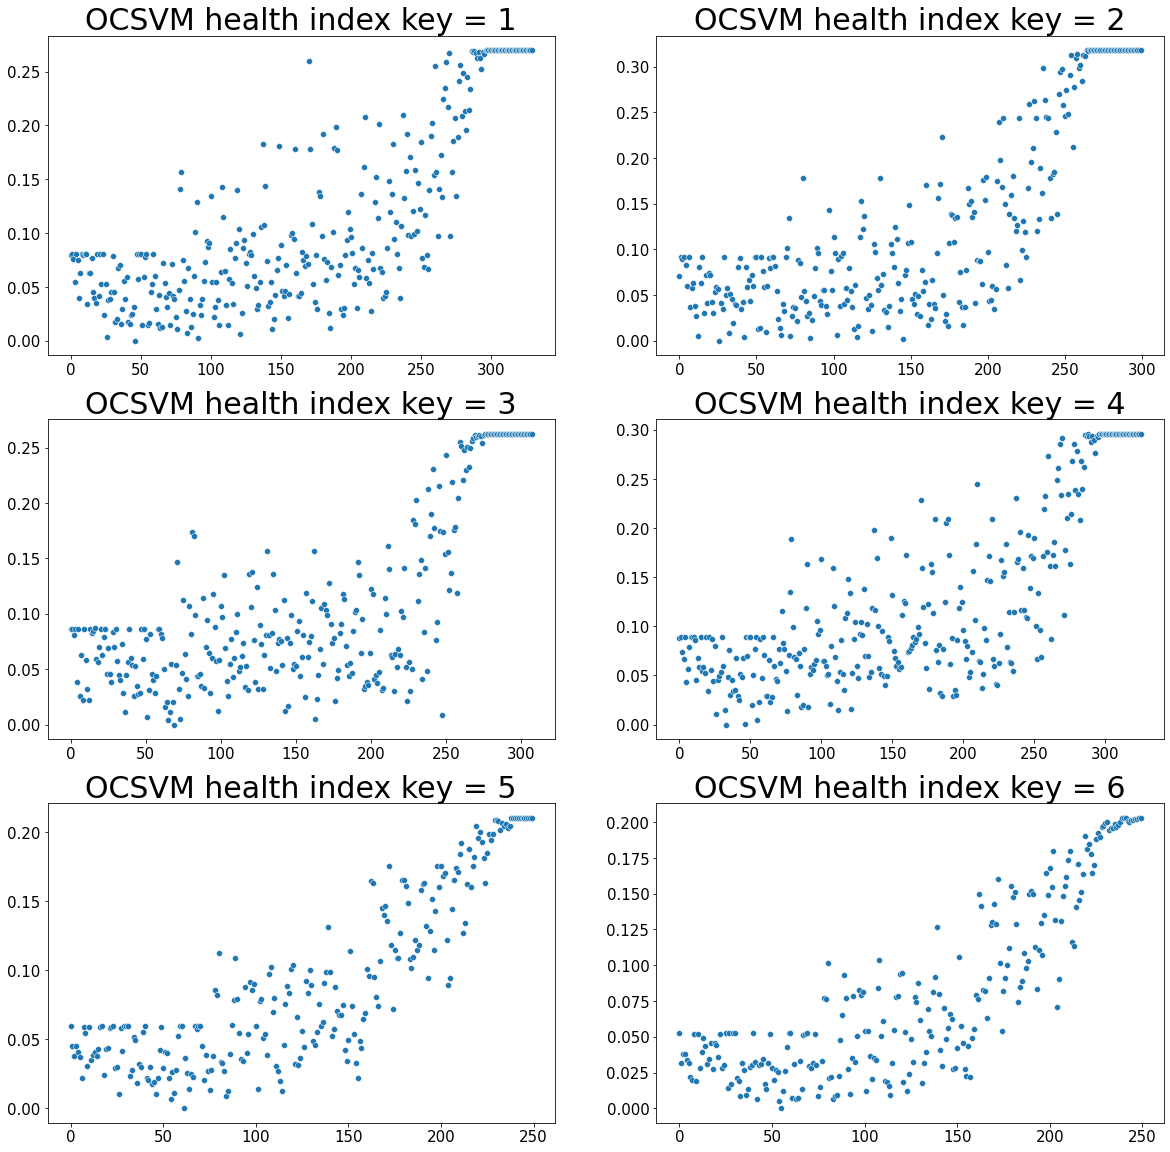

In [37]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'OCSVM')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

OCSVM(cache_size=200, coef0=0.0, contamination=0.01, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.01, shrinking=True, tol=0.001,
   verbose=False)


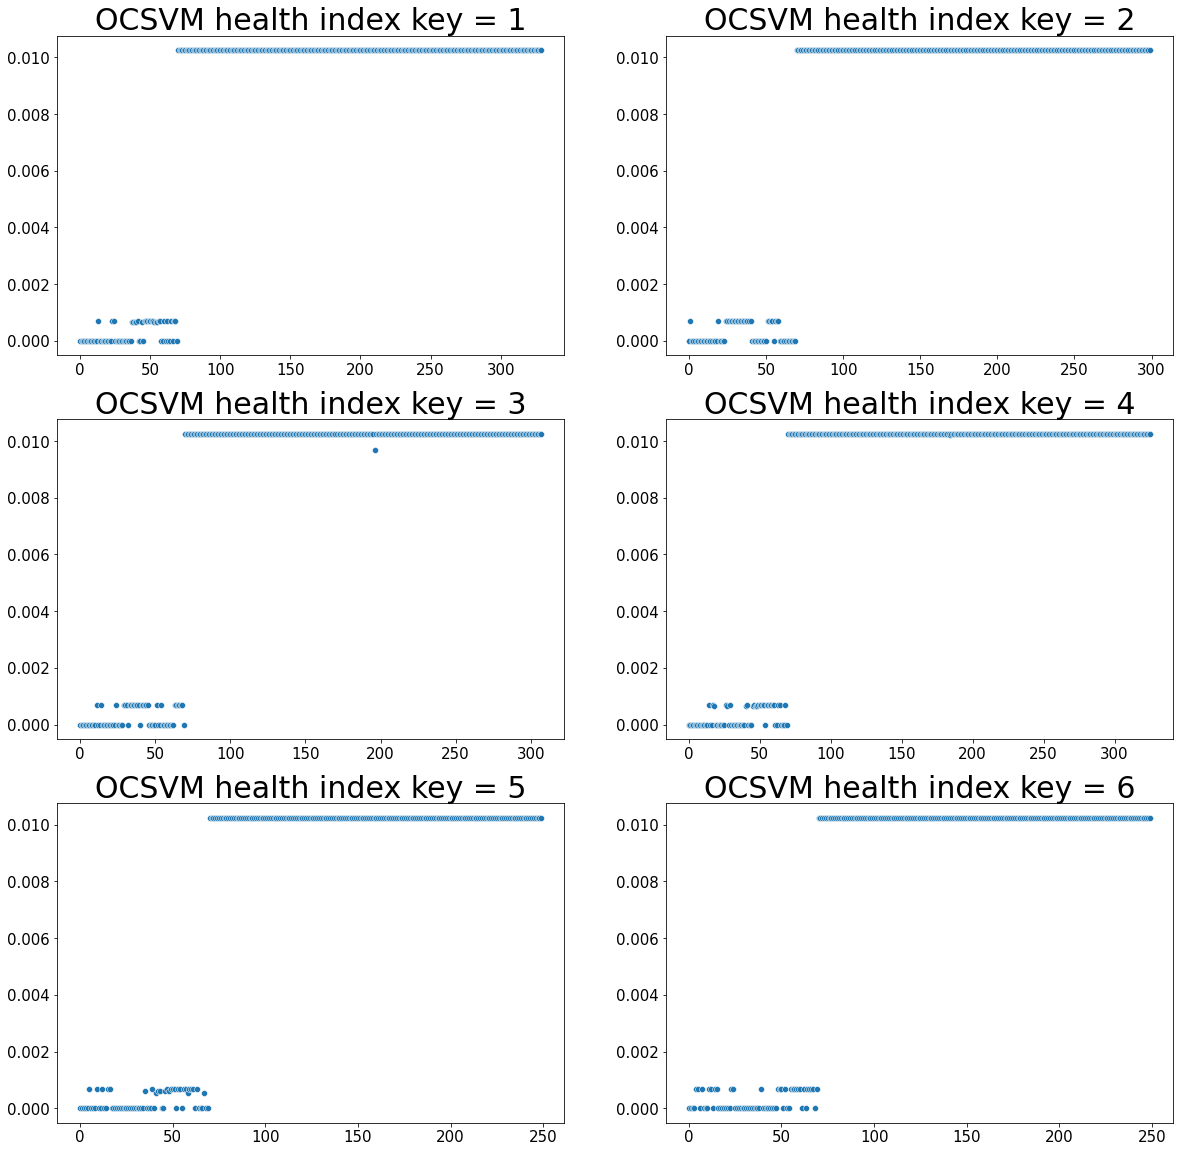

In [38]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'OCSVM')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

# GMM

0.39588441699926685
1.6209180028338506
2.4928069229284304
1.3031410164423214
1.6959655536630236
0.7865612085288008
GMM(contamination=0.1, covariance_type='full', init_params='kmeans',
  max_iter=100, means_init=None, n_components=2, n_init=1,
  precisions_init=None, random_state=None, reg_covar=1e-06, tol=0.001,
  warm_start=False, weights_init=None)


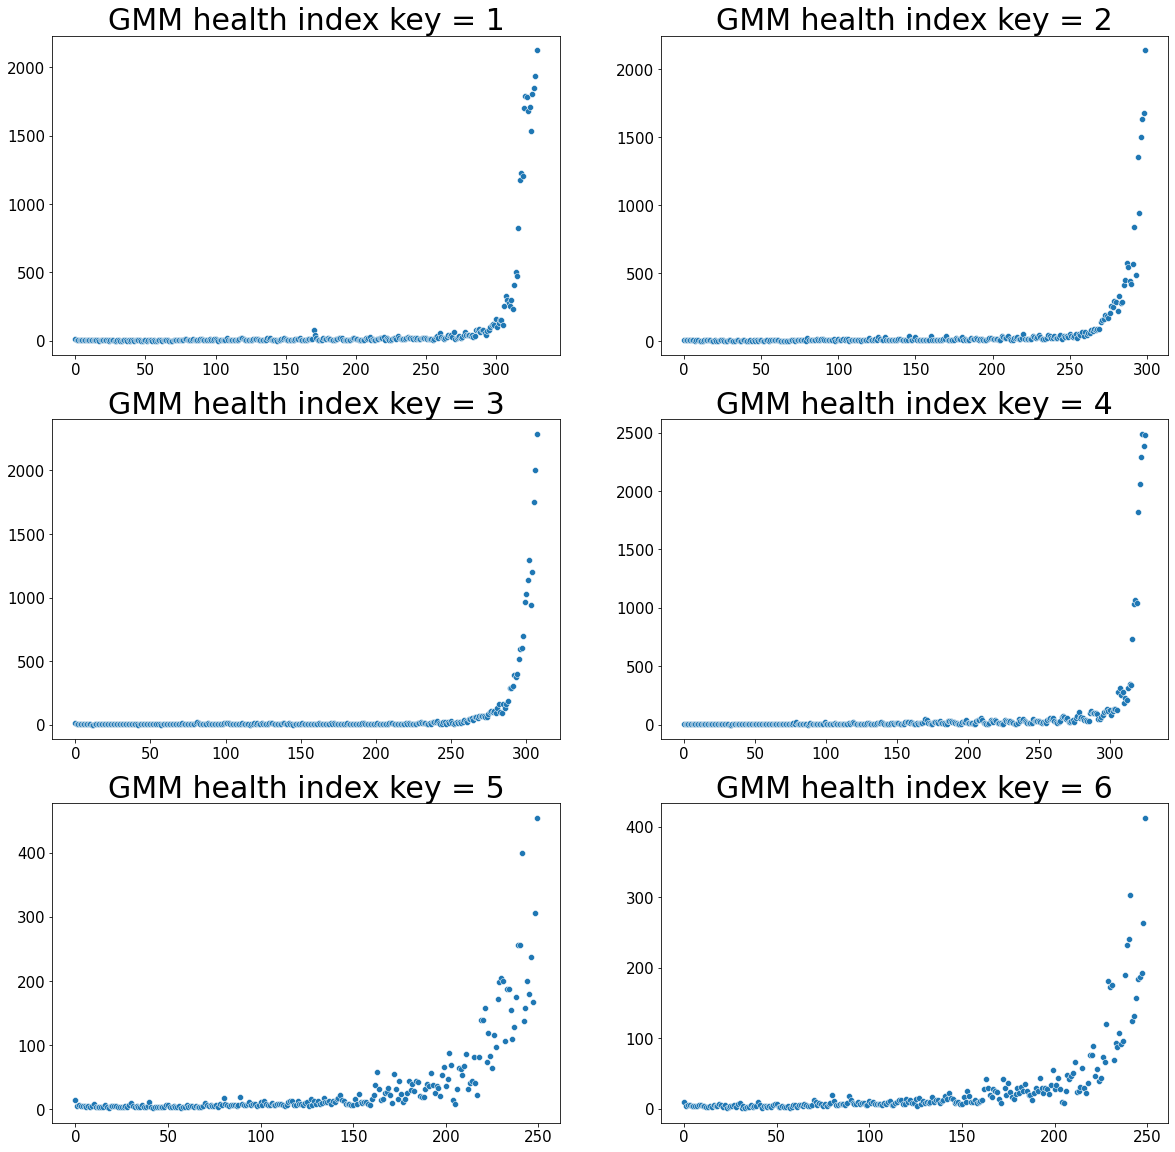

In [43]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'GMM', param_dict = {'n_components': 2})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

GMM(contamination=0.1, covariance_type='full', init_params='kmeans',
  max_iter=100, means_init=None, n_components=2, n_init=1,
  precisions_init=None, random_state=None, reg_covar=1e-06, tol=0.001,
  warm_start=False, weights_init=None)


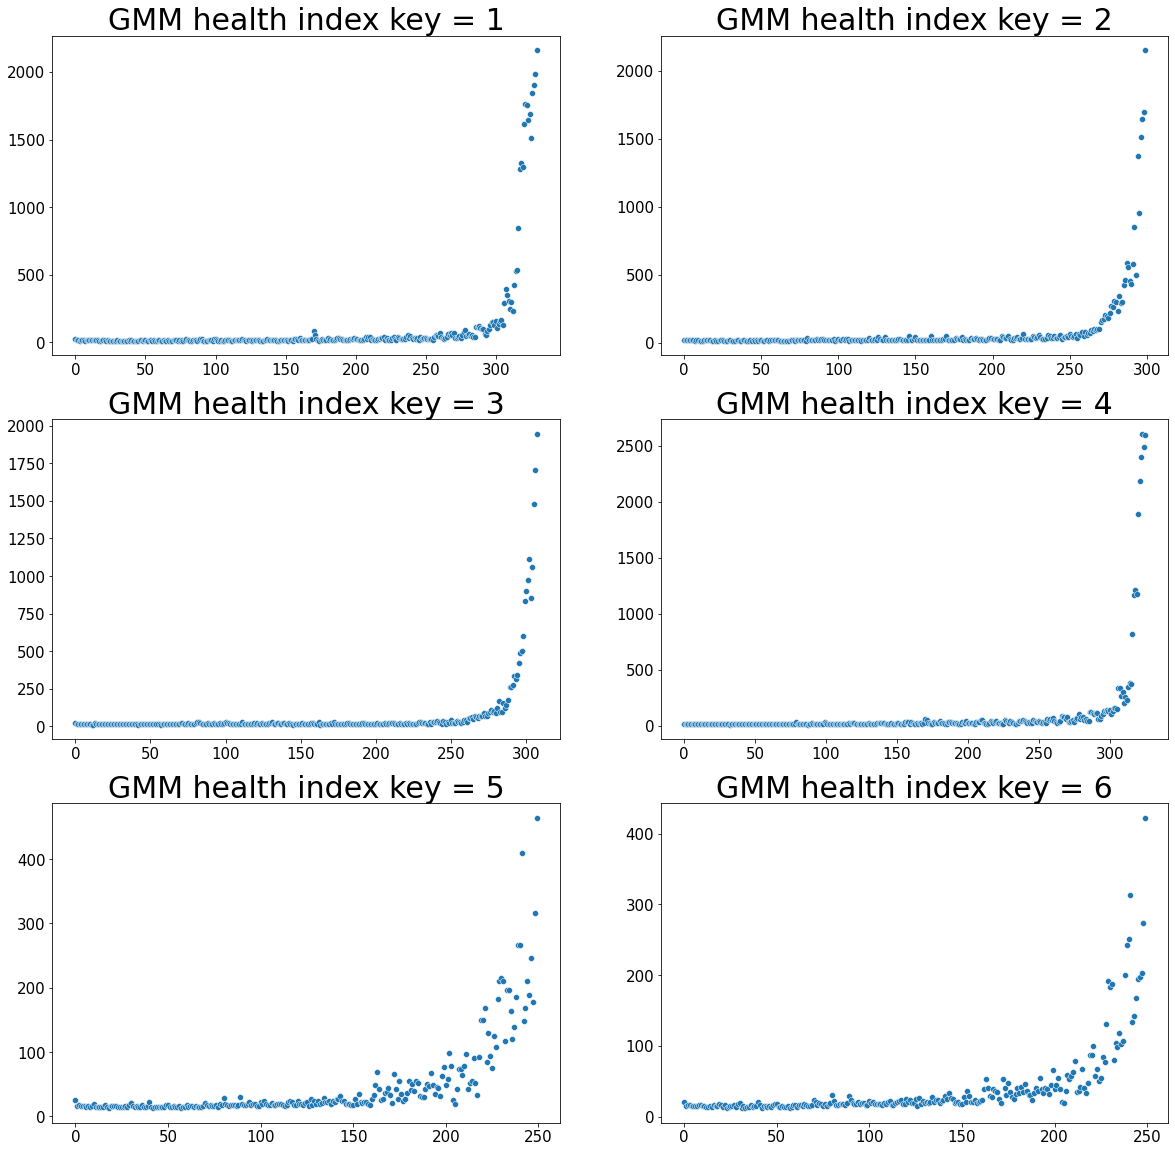

In [23]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'GMM', param_dict = {'n_components':2, 'covariance_type': 'full'})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

# Isolation Forest

IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=200, n_jobs=1,
    random_state=None, verbose=0)


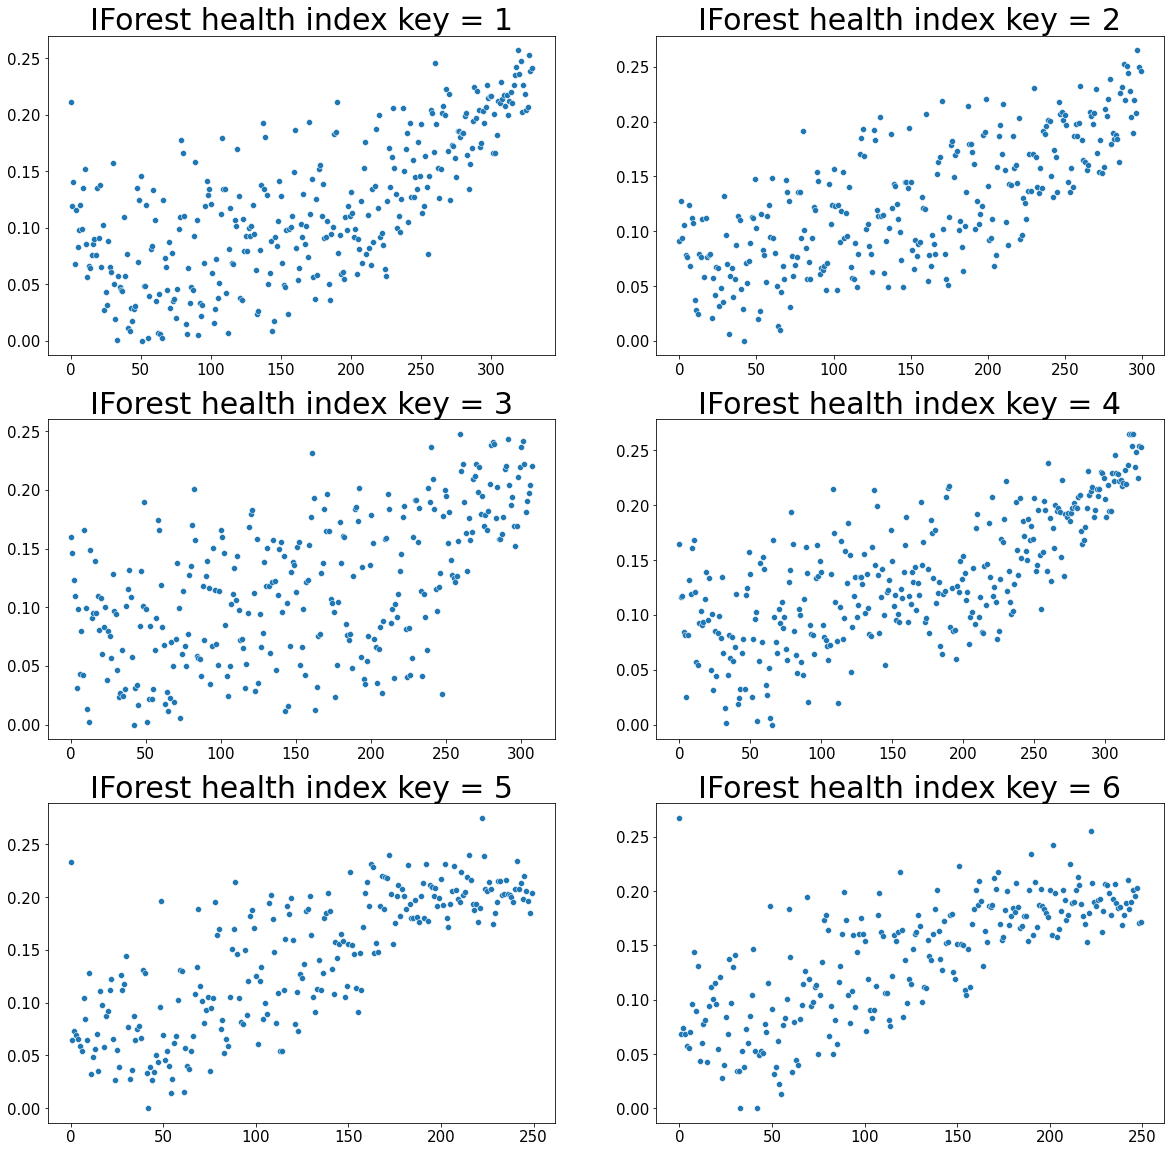

In [24]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'IForest', param_dict = {'n_estimators': 200})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=200, n_jobs=1,
    random_state=None, verbose=0)


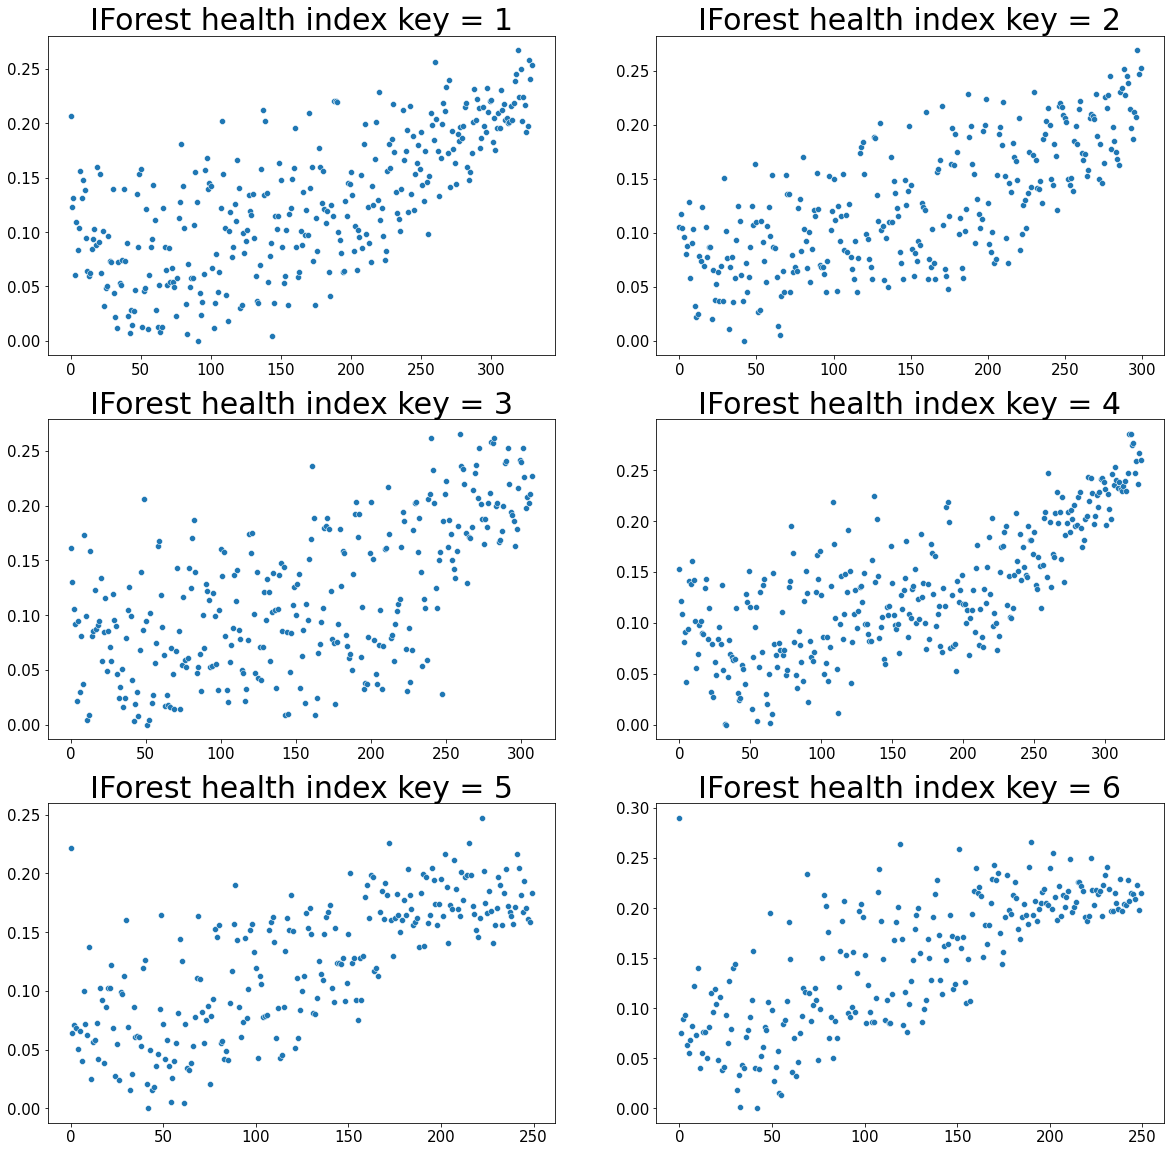

In [25]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'IForest', param_dict = {'n_estimators': 200})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

# AutoEncoder

Epoch 11: early stopping
11/11 [==============================] - 0s 3ms/step
Epoch 25: early stopping
10/10 [==============================] - 0s 3ms/step
Epoch 11: early stopping
10/10 [==============================] - 0s 2ms/step
Epoch 11: early stopping
11/11 [==============================] - 1s 2ms/step
Epoch 38: early stopping
8/8 [==============================] - 0s 3ms/step
Epoch 11: early stopping
8/8 [==============================] - 0s 3ms/step


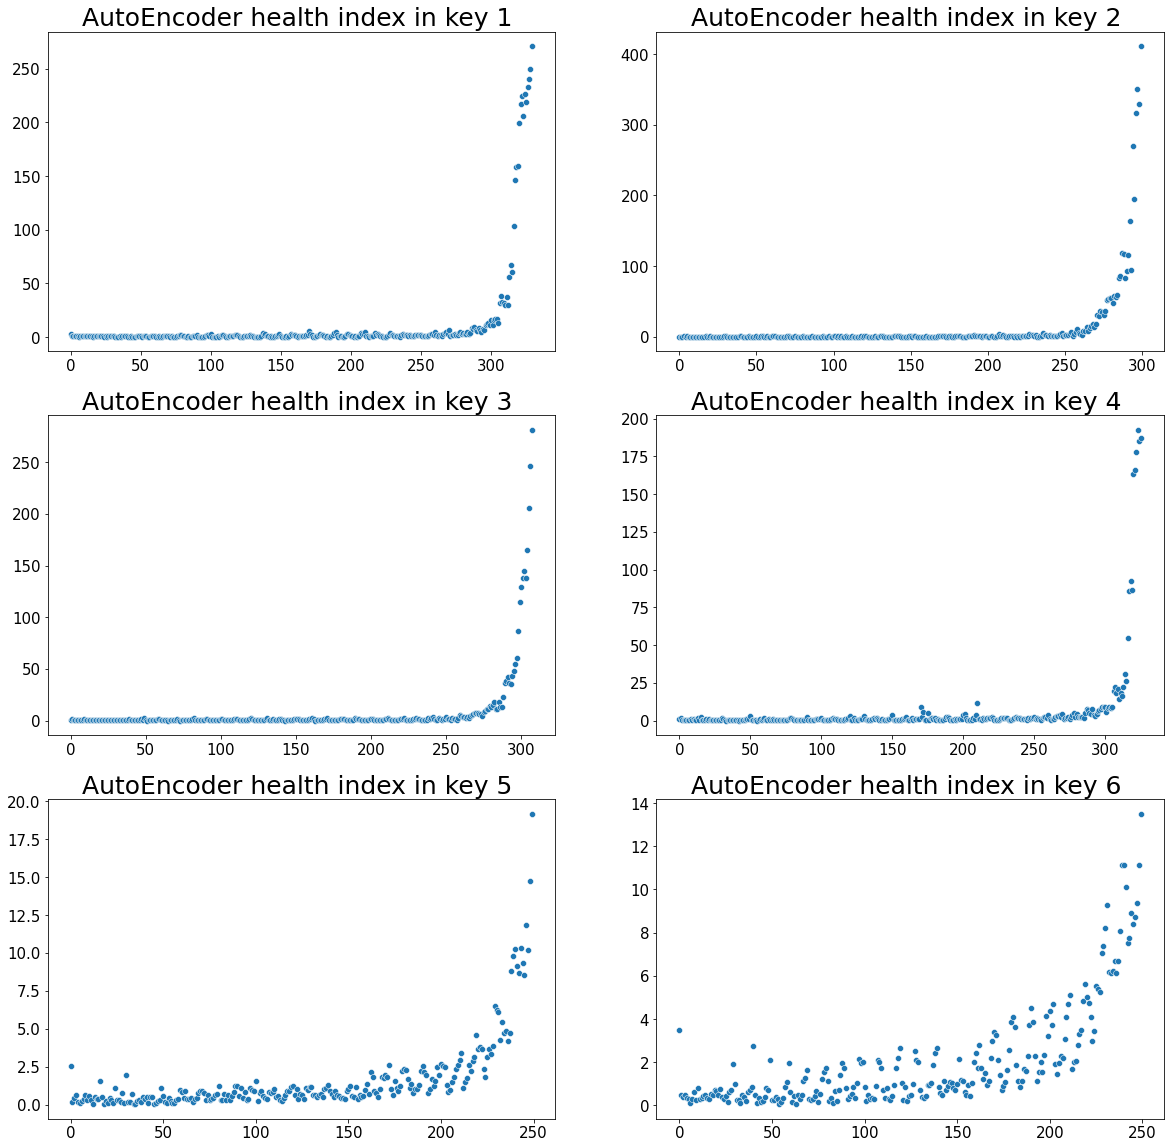

In [26]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'AE')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
print(model)

10/10 [==============================] - 0s 2ms/step
Epoch 23: early stopping
11/11 [==============================] - 0s 3ms/step
Epoch 23: early stopping
8/8 [==============================] - 0s 3ms/step


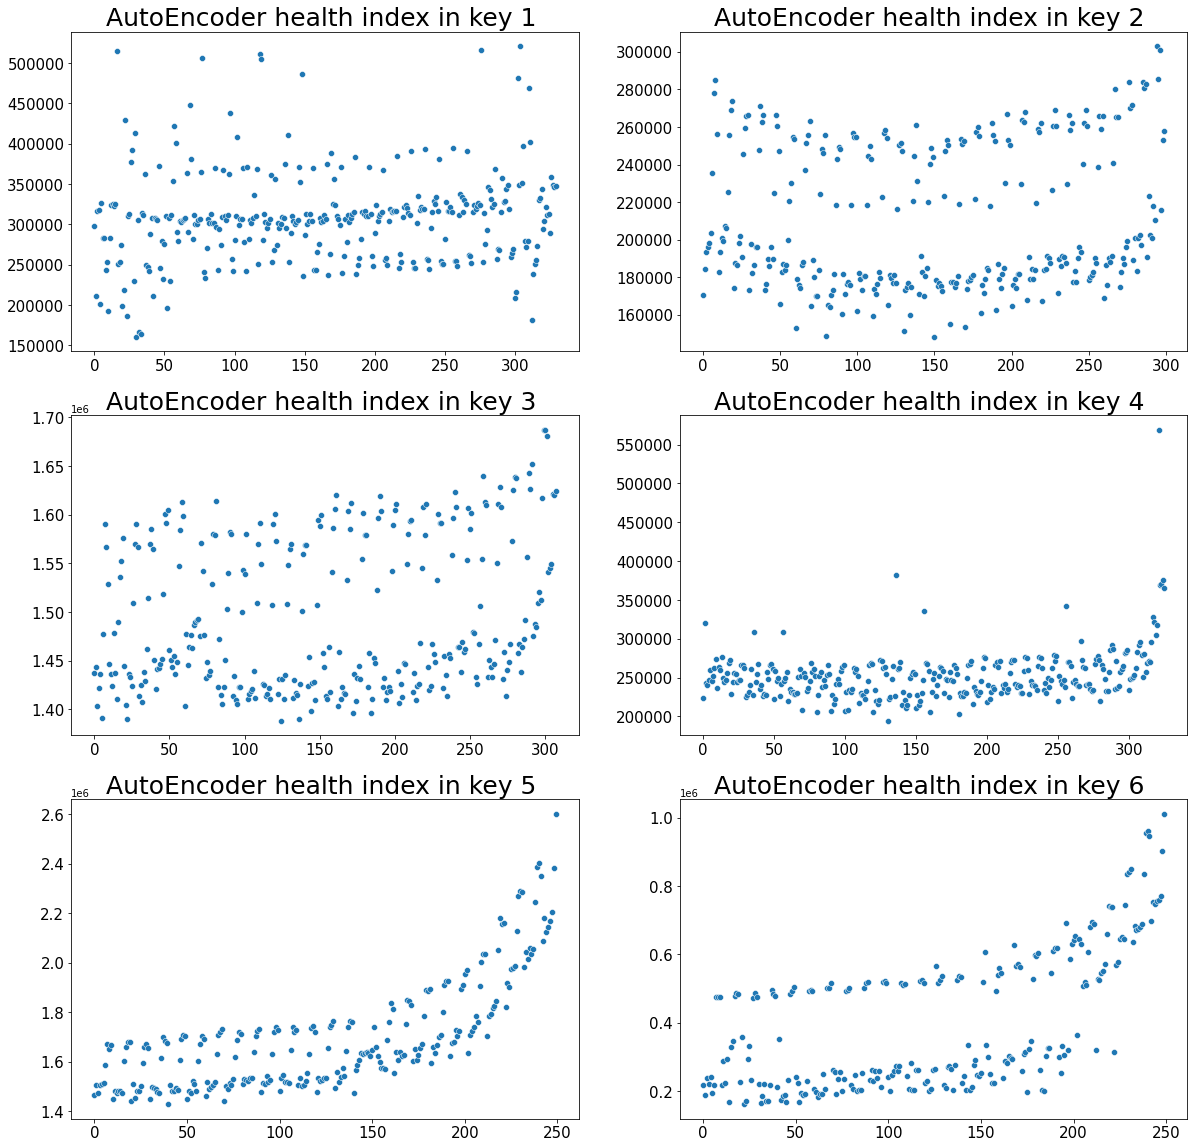

In [35]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'AE', param_dict = {'momentum': 0.6, 'learning_rate': 0.03,'patience':20})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
print(model)